-----------------------------------------------------------------------------------------------------------------------------------
# 🧠 FREQUENCY-DOMAIN WATERMARKING: A UNIFIED ANALYSIS OF DCT, DFT, AND DWT
-----------------------------------------------------------------------------------------------------------------------------------

This notebook was developed as part of a research and learning project to explore and compare classical transform-domain watermarking techniques—DCT, DFT, and DWT—through both theoretical understanding and hands-on implementation. The project emphasizes comparisons between manual and built-in functions, with a focus on evaluating visual fidelity and computational efficiency.

Developed by [Dipanshu Modi](https://github.com/dipanshumodi31)

##  ENVIRONMENT SETUP AND IMAGE LOADING

This cell imports the necessary libraries for image processing, visualization, performance evaluation, and watermarking (DWT-based). It performs the following operations:

- Loads the grayscale version of the image `professional.jpg` using OpenCV.
- Verifies the successful loading of the image and raises an error if the path is incorrect.
- Displays the original grayscale image using `matplotlib`.

This setup is crucial for initializing the environment and preparing the input for watermark embedding and analysis in subsequent cells.

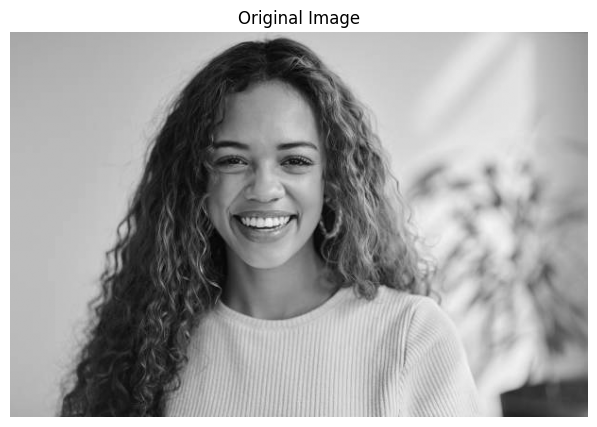

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time
import pywt

img = cv2.imread('professional.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
img_small = cv2.imread('professional.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found. Please check the path.")

plt.figure(figsize=(10,5))
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

-----------------------------------------------------------------------------------------------------------------------------------
# DCT WATERMARKING
-----------------------------------------------------------------------------------------------------------------------------------

## MANUAL DCT BASED WATERMARKING AND EXTRACTION

This cell performs **watermark embedding and extraction using a manually implemented 2D Discrete Cosine Transform (DCT)**, without relying on OpenCV’s built-in DCT functions.

1. **Manual DCT and IDCT Implementation**:
   - Custom functions `dct_2d()` and `idct_2d()` are defined based on the mathematical formulation of 2D DCT.
   - These functions use DCT basis matrices to transform the image to and from the frequency domain.
   - Execution time for both transformations is recorded for performance comparison.

2. **DCT Visualization**:
   - The DCT coefficients are logarithmically scaled and normalized for improved visibility.
   - The pre-watermark DCT visualization is saved as `DCTbefore_manual.png`.

3. **Watermark Embedding**:
   - The watermark text `"V7Shinobi"` is converted to a binary bitstream.
   - This bitstream is embedded into the DCT coefficients by incrementing or decrementing the first few coefficients based on the corresponding bit.

4. **Inverse DCT and Image Recovery**:
   - The modified DCT is transformed back to the spatial domain using the custom `idct_2d()` function.
   - The watermarked image is saved as `DCT_watermarked_manual.png`.

5. **Watermark Extraction**:
   - Both the original and watermarked images are transformed using the manual DCT.
   - The differences between their corresponding DCT coefficients are used to extract the embedded watermark bits.
   - Extracted bits are grouped and converted back into characters to reconstruct the original watermark.

6. **Quality Assessment**:
   - PSNR and SSIM are calculated to evaluate image quality degradation due to watermarking.

**Purpose**: Highlights a low-level approach to watermarking using manually computed DCT and IDCT. This offers better insight into the inner workings of frequency-domain watermarking techniques and allows performance benchmarking against built-in implementations.


Extracted Manual Watermark: V7Shinobi


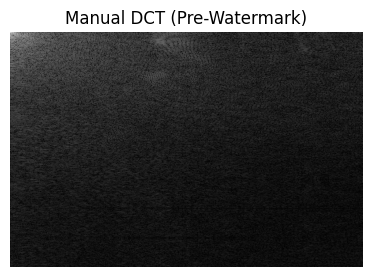

In [2]:
def dct_2d(image):
    image = np.array(image, dtype=np.float32)
    M, N = image.shape

    def create_dct_matrix(n):
        dct = np.zeros((n, n))
        for k in range(n):
            for i in range(n):
                if k == 0:
                    dct[k, i] = 1 / np.sqrt(n)
                else:
                    dct[k, i] = np.sqrt(2 / n) * np.cos((np.pi * (2 * i + 1) * k) / (2 * n))
        return dct
    C_M = create_dct_matrix(M)
    C_N = create_dct_matrix(N)
    return C_M @ image @ C_N.T

def idct_2d(dct_coeff):
    dct_coeff = np.array(dct_coeff, dtype=np.float32)
    M, N = dct_coeff.shape

    def create_dct_matrix(n):
        dct = np.zeros((n, n))
        for k in range(n):
            for i in range(n):
                if k == 0:
                    dct[k, i] = 1 / np.sqrt(n)
                else:
                    dct[k, i] = np.sqrt(2 / n) * np.cos((np.pi * (2 * i + 1) * k) / (2 * n))
        return dct

    C_M = create_dct_matrix(M)
    C_N = create_dct_matrix(N)
    return C_M.T @ dct_coeff @ C_N

start_dct = time.time()
dct_img2 = dct_2d(img)
end_dct = time.time()
time_dct_manual = end_dct - start_dct

dct_manual_img = np.log(np.abs(dct_img2) + 1)
dct_manual_img = cv2.normalize(dct_manual_img, None, 0, 255, cv2.NORM_MINMAX)
dct_manual_img = np.uint8(dct_manual_img)
cv2.imwrite('DCTbefore_manual.png', dct_manual_img)


flat_dct_manual = dct_img2.flatten()
watermark_text_manual = "V7Shinobi"
watermark_bin_manual = ''.join(format(ord(char), '08b') for char in watermark_text_manual)

flat_dct_manual = np.round(flat_dct_manual)

for i, bit in enumerate(watermark_bin_manual):
    flat_dct_manual[i] = flat_dct_manual[i] + 1 if bit == '1' else flat_dct_manual[i] - 1

watermarked_dct_manual = flat_dct_manual.reshape(dct_img2.shape)

start_idct = time.time()
watermarked_img_manual = idct_2d(watermarked_dct_manual)
end_idct = time.time()
time_idct_manual = end_idct - start_idct

watermarked_img_manual = np.clip(watermarked_img_manual, 0, 255).astype(np.uint8)
cv2.imwrite("DCT_watermarked_manual.png", watermarked_img_manual)

watermarked_manual_loaded = watermarked_img_manual

dct_original_manual = dct_2d(img)
dct_watermarked_manual = dct_2d(watermarked_manual_loaded)

flat_orig_manual = dct_original_manual.flatten()
flat_watermarked_manual = dct_watermarked_manual.flatten()

extracted_bits_manual = ""
for i in range(len(watermark_bin_manual)):
    diff = flat_watermarked_manual[i] - flat_orig_manual[i]
    bit = '1' if diff > 0.5 else '0'
    extracted_bits_manual += bit

extracted_text_manual = ''.join(
    chr(int(extracted_bits_manual[i:i+8], 2)) for i in range(0, len(extracted_bits_manual), 8)
)

print("Extracted Manual Watermark:", extracted_text_manual)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dct_manual_img, cmap='gray')
plt.title("Manual DCT (Pre-Watermark)")
plt.axis('off')
plt.show()

if img.shape == watermarked_manual_loaded.shape:
    psnr_manual = psnr(img, watermarked_manual_loaded)
    ssim_manual = ssim(img, watermarked_manual_loaded)
else:
    print("Images must have the same dimensions for PSNR/SSIM.")

## BUILT-IN DCT BASED WATERMARKING AND EXTRACTION

This cell implements **watermark embedding and extraction using OpenCV’s built-in DCT (Discrete Cosine Transform)** functionality.

1. **DCT Transformation**:
   - The original grayscale image is transformed using `cv2.dct()` to the frequency domain.
   - The DCT coefficients are visualized using logarithmic scaling and normalization.

2. **Watermark Embedding**:
   - A text watermark (`"V7Shinobi"`) is converted into a binary string.
   - The binary watermark is embedded in the low-frequency DCT coefficients by incrementing or decrementing values based on bit values.

3. **Inverse DCT**:
   - The modified DCT coefficients are transformed back to the spatial domain using `cv2.idct()` to get the watermarked image.
   - The image is clipped and saved as `DCT_watermarked_builtin.png`.

4. **Watermark Extraction**:
   - The same DCT transformation is applied to both original and watermarked images.
   - Differences in corresponding DCT coefficients are used to extract embedded bits.
   - The bits are grouped and converted back to characters to retrieve the watermark.

5. **Quality Assessment**:
   - PSNR and SSIM metrics are computed if dimensions match to assess visual similarity between the original and watermarked images.

**Purpose**: Demonstrates how to embed and recover a textual watermark using OpenCV’s built-in DCT, showcasing ease of use and effectiveness for robust watermarking.


Extracted Watermark: V7Shinobi


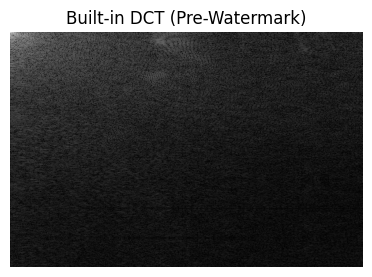

In [3]:
start_dct_b = time.time()
dct_img = cv2.dct(np.float32(img))
end_dct_b = time.time()
time_dct_b = end_dct_b - start_dct_b

dct_builtin_vis = np.log(np.abs(dct_img) + 1)  # for visibility
dct_builtin_vis = cv2.normalize(dct_builtin_vis, None, 0, 255, cv2.NORM_MINMAX)
dct_builtin_vis = np.uint8(dct_builtin_vis)
cv2.imwrite('DCTbefore_builtin.png', dct_builtin_vis)

flat_dct = dct_img.flatten()

watermark_text = "V7Shinobi"
watermark_bin = ''.join(format(ord(char), '08b') for char in watermark_text)

flat_dct = np.round(flat_dct)

for i, bit in enumerate(watermark_bin):
    flat_dct[i] = flat_dct[i] + 1 if bit == '1' else flat_dct[i] - 1

watermarked_dct = flat_dct.reshape(dct_img.shape)

start_idct_b = time.time()
watermarked_img = cv2.idct(watermarked_dct)
end_idct_b = time.time()
time_idct_b = end_idct_b - start_idct_b

watermarked_img = np.clip(watermarked_img, 0, 255).astype(np.uint8)
cv2.imwrite("DCT_watermarked_builtin.png", watermarked_img)

watermarked_loaded = watermarked_img  # better than reloading from disk

dct_original = cv2.dct(np.float32(img))
dct_watermarked = cv2.dct(np.float32(watermarked_loaded))

flat_orig = dct_original.flatten()
flat_watermarked = dct_watermarked.flatten()

extracted_bits = ""
for i in range(len(watermark_bin)):
    diff = flat_watermarked[i] - flat_orig[i]
    bit = '1' if diff > 0.5 else '0'
    extracted_bits += bit

extracted_text = ''.join(
    chr(int(extracted_bits[i:i+8], 2)) for i in range(0, len(extracted_bits), 8)
)

print("Extracted Watermark:", extracted_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.imshow(dct_builtin_vis, cmap='gray')
plt.title("Built-in DCT (Pre-Watermark)")
plt.axis('off')
plt.show()

if img.shape == watermarked_loaded.shape:
    psnr_value = psnr(img, watermarked_loaded)
    ssim_value = ssim(img, watermarked_loaded)
else:
    print("Images must have the same dimensions for PSNR/SSIM.")


## DCT WATERMARK VISUALIZATION AND DIFFERENCE ANALYSIS

This cell visually compares the results of manual and built-in DCT watermarking methods and highlights their differences.

1. **Difference Calculation**:  
   - Computes the absolute difference between the manual DCT coefficients (`dct_img2`) and the built-in DCT coefficients (`dct_img`).  
   - Applies logarithmic scaling and normalization for better visualization of differences.  
   - Saves the difference image as `dct_difference_manual_builtin.png`.

2. **Visualization**:  
   - Displays side-by-side plots comparing:  
     - Manual DCT coefficients after watermark embedding (log-scaled).  
     - The manually watermarked spatial domain image.  
     - The difference image highlighting changes between manual and built-in DCT coefficients.  
     - Built-in DCT coefficients after watermark embedding (log-scaled).  
     - The watermarked image obtained via built-in DCT.

3. **Purpose**:  
   - Provides visual insight into how watermark embedding modifies DCT coefficients.  
   - Allows comparison between manual and built-in DCT implementations.  
   - Helps in analyzing the fidelity and subtle differences between watermarking approaches.

This visualization aids in better understanding the impact of watermark embedding in the frequency domain and the quality of the watermarked images produced by both methods.


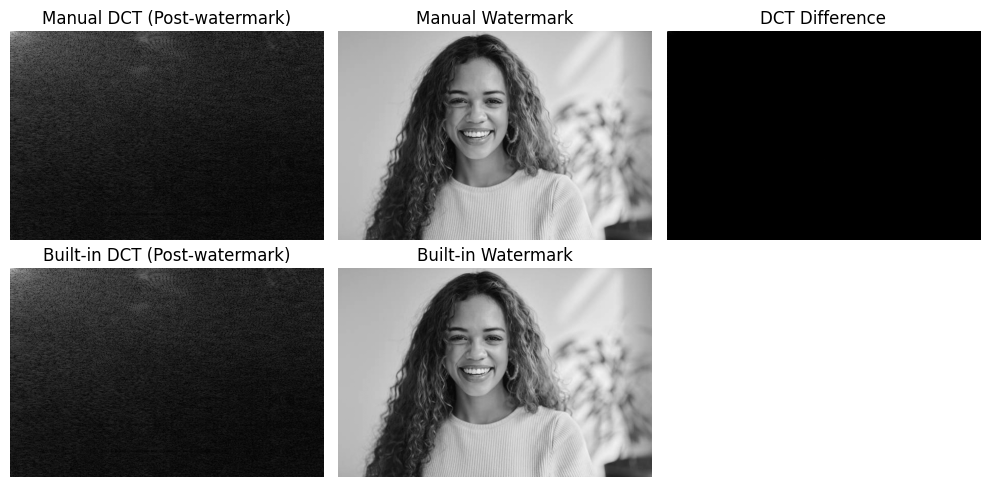

In [4]:
dct_diff = np.abs(dct_img2 - dct_img)
dct_diff_vis = np.log(dct_diff + 1)
dct_diff_vis = cv2.normalize(dct_diff_vis, None, 0, 255, cv2.NORM_MINMAX)
dct_diff_vis = np.uint8(dct_diff_vis)
cv2.imwrite('dct_difference_manual_builtin.png', dct_diff_vis)

plt.figure(figsize=(10, 5))
plt.subplot(2, 3, 1)
plt.imshow(np.log(np.abs(dct_img2) + 1), cmap='gray')
plt.title("Manual DCT (Post-watermark)")
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(watermarked_img_manual, cmap='gray')
plt.title("Manual Watermark")
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(dct_diff_vis, cmap='gray')
plt.title("DCT Difference")
plt.axis('off')
plt.subplot(2, 3, 4)
dct_vis = np.log(np.abs(dct_img) + 1)
plt.imshow(dct_vis, cmap='gray')
plt.title("Built-in DCT (Post-watermark)")
plt.axis('off')
plt.subplot(2, 3, 5)
dct_vis = np.log(np.abs(dct_img) + 1)
plt.imshow(watermarked_img, cmap='gray')
plt.title("Built-in Watermark")
plt.axis('off')
plt.tight_layout()
plt.show()

## METRICS OF DCT WATERMARKING METHODS

This cell evaluates and compares the performance of the manual and built-in DCT watermarking techniques using several image quality metrics and processing times.

1. **Image Quality Metrics**:  
   - **PSNR (Peak Signal-to-Noise Ratio)**: Measures the peak error between the original and watermarked images, indicating the level of distortion.  
   - **SSIM (Structural Similarity Index)**: Assesses perceptual similarity by comparing luminance, contrast, and structure between images.  
   - **RMSE (Root Mean Squared Error)**: Calculates the average magnitude of pixel-wise errors.

2. **Processing Time**:  
   - Records the time taken to perform the DCT and inverse DCT (IDCT) transformations for both manual and built-in methods.

3. **Results Presentation**:  
   - Organizes all metrics and timing data into a clear, tabular format for easy comparison.

4. **Purpose**:  
   - Provides a quantitative basis to compare the visual quality and computational efficiency of the two watermarking implementations.  
   - Helps to assess the trade-offs between accuracy and speed in practical watermark embedding and extraction.

This comprehensive metric comparison supports informed decisions on the preferred DCT-based watermarking approach.


In [5]:
psnr_dct_manual = psnr(img, watermarked_img_manual)
ssim_dct_manual = ssim(img, watermarked_img_manual, channel_axis=-1)
rmse_dct_manual = np.sqrt(np.mean((img - watermarked_img_manual) ** 2))
psnr_dct_builtin = psnr(img, watermarked_img)
ssim_dct_builtin = ssim(img, watermarked_img, channel_axis=-1)
rmse_dct_builtin = np.sqrt(np.mean((img - watermarked_img) ** 2))

dct_metrics = {
    "Method": ["Manual DCT", "Built-in DCT"],
    "PSNR (dB)": [psnr_dct_manual, psnr_dct_builtin],
    "SSIM": [ssim_dct_manual, ssim_dct_builtin],
    "RMSE": [rmse_dct_manual, rmse_dct_builtin],
    "Time DCT (s)": [time_dct_manual, time_dct_b],
    "Time IDCT (s)": [time_idct_manual, time_idct_b],
}

df_dct_metrics = pd.DataFrame(dct_metrics)
df_dct_metrics


,Method,PSNR (dB),SSIM,RMSE,Time DCT (s),Time IDCT (s)
0,Manual DCT,51.096150,0.997029,0.710776,1.172670,1.299767
1,Built-in DCT,51.095255,0.997030,0.710849,0.027998,0.007410


-----------------------------------------------------------------------------------------------------------------------------------
# DFT WATERMARKING
-----------------------------------------------------------------------------------------------------------------------------------

## MANUAL DFT-BASED WATERMARKING WITH FREQUENCY MASKING


This cell implements watermark embedding in the frequency domain using a **custom 2D Discrete Fourier Transform (DFT)** and its inverse.

1. **Custom DFT/IDFT Functions**:  
   - Defines custom functions to compute 1D and 2D DFT and inverse DFT (IDFT) from scratch using the mathematical definitions.
   - Applies the custom 2D DFT to the grayscale image to transform it into the frequency domain.

2. **Frequency Magnitude Visualization**:  
   - Computes the logarithmic magnitude spectrum of the original DFT coefficients for visualization and normalization.
   - Saves this magnitude image before watermarking.

3. **Watermark Pattern Creation**:  
   - Generates a spatial watermark pattern with text `"v7shinobi"` placed on a blank image.
   - This pattern will be embedded selectively in a ring-shaped region in the frequency domain.

4. **Watermark Embedding in Frequency Domain**:  
   - Decomposes the DFT coefficients into magnitude and phase.
   - Defines a circular ring mask in the frequency domain to localize watermark embedding, avoiding low and high frequencies.
   - Modifies the magnitude spectrum by adding a scaled watermark pattern (weighted by alpha = 100) inside the ring mask.
   - Combines the modified magnitude with the original phase to reconstruct the frequency domain representation.

5. **Inverse DFT and Image Reconstruction**:  
   - Applies the custom inverse 2D DFT to obtain the spatial domain watermarked image.
   - Normalizes and saves the watermarked image.

6. **Difference Analysis and Visualization**:  
   - Calculates and normalizes differences between the original and watermarked frequency magnitudes.
   - Computes and normalizes the pixel-wise difference between the original and watermarked images.
   - Saves these difference images and plots them side-by-side for comparison.

**Purpose**:  
- Demonstrates watermark embedding in the frequency domain via custom DFT implementations and controlled spatial masking, allowing localized watermark insertion while preserving image quality.
- Provides insight into the frequency domain modifications and their spatial impact through visualization of difference images.

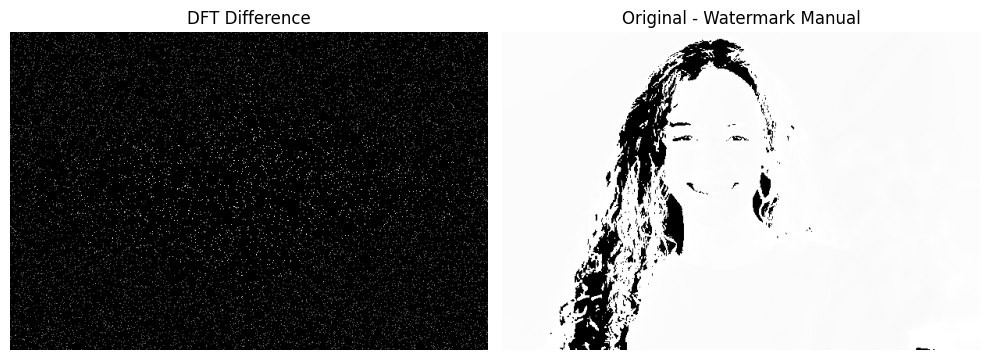

In [6]:
def custom_dft1(signal):
    N = len(signal)
    result = np.zeros(N, dtype=complex)
    for k in range(N):
        angle = -2j * np.pi * k * np.arange(N) / N
        result[k] = np.sum(signal * np.exp(angle))
    return result

def custom_idft1(signal):
    N = len(signal)
    result = np.zeros(N, dtype=complex)
    for n in range(N):
        angle = 2j * np.pi * n * np.arange(N) / N
        result[n] = np.sum(signal * np.exp(angle)) / N
    return result

def custom_dft2(image):
    M, N = image.shape
    row_dft = np.zeros((M, N), dtype=complex)
    for i in range(M):
        row_dft[i, :] = custom_dft1(image[i, :])
    dft = np.zeros((M, N), dtype=complex)
    for j in range(N):
        dft[:, j] = custom_dft1(row_dft[:, j])
    return dft

def custom_idft2(dft):
    M, N = dft.shape
    col_idft = np.zeros((M, N), dtype=complex)
    for j in range(N):
        col_idft[:, j] = custom_idft1(dft[:, j])
    idft = np.zeros((M, N), dtype=complex)
    for i in range(M):
        idft[i, :] = custom_idft1(col_idft[i, :])
    return np.abs(idft)

start_dft = time.time()
dft_original = custom_dft2(img)
end_dft = time.time()
time_dft_manual = end_dft - start_dft

magnitude_orig = np.log1p(np.abs(np.fft.fftshift(dft_original)))
magnitude_norm = cv2.normalize(magnitude_orig, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_before_manual.jpg', magnitude_norm)

watermark_manual = np.zeros_like(img)
cv2.putText(watermark_manual, 'v7shinobi', (5, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255, 1, cv2.LINE_AA)
cv2.imwrite('DFT_watermark_pattern_manual.jpg', watermark_manual)

alpha = 100
magnitude = np.abs(dft_original)
phase = np.angle(dft_original)

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
radius_inner = 20
radius_outer = 60
Y, X = np.ogrid[:rows, :cols]
distance = np.sqrt((X - ccol) ** 2 + (Y - crow) ** 2)
ring_mask = ((distance >= radius_inner) & (distance <= radius_outer)).astype(np.float32)

watermark_resized = cv2.resize(watermark_manual, (cols, rows))
watermark_normalized = watermark_resized / 255.0
magnitude_with_wm = magnitude + alpha * (ring_mask * watermark_normalized)

dft_modified = magnitude_with_wm * np.exp(1j * phase)

magnitude_modified = np.log1p(np.abs(np.fft.fftshift(dft_modified)))
magnitude_mod_manual = cv2.normalize(magnitude_modified, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_after_manual.jpg', magnitude_mod_manual)

start_idft = time.time()
img_watermarked = custom_idft2(dft_modified)
end_idft = time.time()
time_idft_manual = end_idft - start_idft

img_watermarked = cv2.normalize(img_watermarked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_watermarked_manual.jpg', img_watermarked)

watermark = cv2.imread('DFT_watermarked_manual.jpg')

difference_dft_manual = np.abs(magnitude_orig - magnitude_modified)
diff_dft_manual = cv2.normalize(difference_dft_manual, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

difference_image_manual = np.abs(img - img_watermarked)
diff_image_manual = cv2.normalize(difference_image_manual, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_magnitude_diff_manual.jpg', diff_dft_manual)
cv2.imwrite('DFT_spatial_diff_manual.jpg', diff_image_manual)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("DFT Difference")
plt.imshow(diff_dft_manual, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Original - Watermark Manual")
plt.imshow(difference_image_manual, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

## BUILT-IN DFT BASED WATERMARKING WITH FREQUENCY MASKING

This cell performs watermark embedding using OpenCV’s built-in DFT and inverse DFT functions with mid-frequency masking.

1. **DFT Transformation**:  
   - Computes the 2D Discrete Fourier Transform of the input image using `cv2.dft()` with complex output.
   - Shifts the zero-frequency component to the center using `np.fft.fftshift()`.
   - Converts Cartesian coordinates (real and imaginary) to polar form (magnitude and phase).
   - Visualizes and saves the magnitude spectrum before watermarking.

2. **Watermark Pattern Creation**:  
   - Creates a spatial watermark image with the text `"v7shinobi"` placed on a blank image.
   - Normalizes the watermark image to [0,1].

3. **Watermark Embedding in Mid-Frequencies**:  
   - Defines a circular ring mask focusing on mid-frequency components.
   - Scales the watermark and adds it to the magnitude spectrum only within the masked ring region.
   - Converts the modified magnitude and original phase back to Cartesian coordinates.
   - Applies inverse frequency shift (`ifftshift`) preparing for inverse transform.

4. **Inverse DFT and Image Reconstruction**:  
   - Performs inverse DFT using `cv2.idft()` to reconstruct the spatial domain watermarked image.
   - Computes the magnitude and normalizes the watermarked image.
   - Saves the watermarked image.

5. **Difference Analysis and Visualization**:  
   - Computes the absolute difference between original and modified magnitude spectra and normalizes it.
   - Calculates the spatial domain difference between the original and watermarked images.
   - Saves and displays these difference images side-by-side.

**Purpose**:  
- Illustrates how to embed a watermark in the frequency domain using OpenCV’s optimized DFT functions.
- Shows selective embedding in mid-frequency components via a ring mask to balance watermark invisibility and robustness.
- Provides visual comparisons of frequency and spatial domain differences caused by watermark embedding.


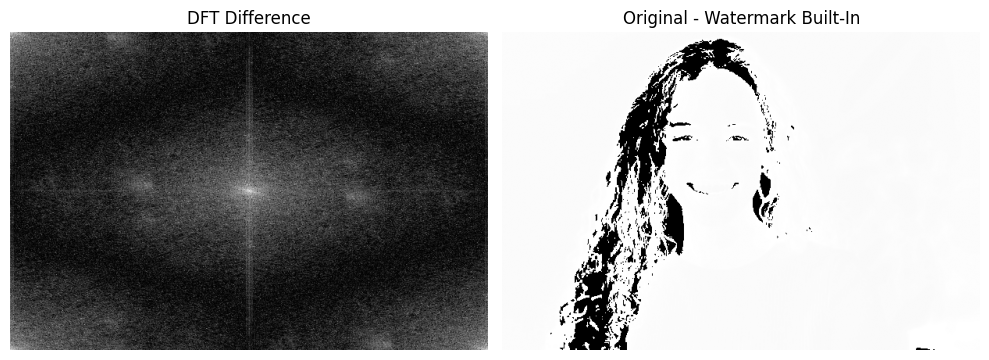

In [7]:
start_dft_b = time.time()
dft = cv2.dft(np.float32(img_small), flags=cv2.DFT_COMPLEX_OUTPUT)
end_dft_b = time.time()
time_dft_b = end_dft_b - start_dft_b

dft_shift = np.fft.fftshift(dft)
magnitude, phase = cv2.cartToPolar(dft_shift[:, :, 0], dft_shift[:, :, 1])
magnitude_orig = np.log1p(magnitude)
magnitude_norm = cv2.normalize(magnitude_orig, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_before_builtin.jpg', magnitude_norm)

watermark_builtin = np.zeros_like(img_small)
cv2.putText(watermark_builtin, 'v7shinobi', (5, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255, 1, cv2.LINE_AA)
dft_watermark_pattern_builtin = cv2.normalize(watermark_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_watermark_pattern_builtin.jpg', dft_watermark_pattern_builtin)

alpha = 100
watermark_normalized = watermark_builtin / 255.0

rows, cols = img_small.shape
crow, ccol = rows // 2, cols // 2
radius_inner = 20
radius_outer = 60
Y, X = np.ogrid[:rows, :cols]
distance = np.sqrt((X - ccol) ** 2 + (Y - crow) ** 2)
ring_mask = ((distance >= radius_inner) & (distance <= radius_outer)).astype(np.float32)

watermark_resized = cv2.resize(watermark_normalized, (cols, rows))

magnitude_with_wm = magnitude + alpha * (ring_mask * watermark_resized)


real, imag = cv2.polarToCart(magnitude_with_wm.astype(np.float32), phase.astype(np.float32))
dft_modified = np.dstack((real, imag))

dft_ishift = np.fft.ifftshift(dft_modified)
magnitude_modified = cv2.magnitude(dft_ishift[:, :, 0], dft_ishift[:, :, 1])
magnitude_modified_log = np.log1p(magnitude_modified)
magnitude_mod_builtin = cv2.normalize(magnitude_modified_log, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_after_builtin.jpg', magnitude_mod_builtin)

start_idft_b = time.time()
img_watermarked_builtin = cv2.idft(dft_ishift)
end_idft_b = time.time()
time_idft_b = end_idft_b - start_idft_b

img_watermarked_builtin = cv2.magnitude(img_watermarked_builtin[:, :, 0], img_watermarked_builtin[:, :, 1])
img_watermarked_builtin = cv2.normalize(img_watermarked_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFT_watermarked_builtin.jpg', img_watermarked_builtin)

watermark_display = cv2.imread('DFT_watermarked_builtin.jpg', cv2.IMREAD_GRAYSCALE)

difference_dft_builtin = np.abs(magnitude_orig - magnitude_modified_log)
diff_dft_builtin = cv2.normalize(difference_dft_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
difference_image_builtin = np.abs(img_small - img_watermarked_builtin)
diff_image_builtin = cv2.normalize(difference_image_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

cv2.imwrite('DFT_magnitude_diff_builtin.jpg', diff_dft_builtin)
cv2.imwrite('DFT_spatial_diff_builtin.jpg', diff_image_builtin)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("DFT Difference")
plt.imshow(diff_dft_builtin, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Original - Watermark Built-In")
plt.imshow(difference_image_builtin, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## COMPARISON OF MANUAL AND BUILT-IN DFT WATERMARKING RESULTS

This cell visualizes and compares the outputs and intermediate results of **manual DFT-based watermarking** and **built-in OpenCV DFT-based watermarking** side by side.

### Visualization Layout:

| Row | Manual DFT                                  | Built-in DFT                               |
|-------|-------------------------------------------|--------------------------------------------|
| 1     | Before DFT magnitude (log-scaled)          | Before DFT magnitude (normalized)          |
| 2     | After embedding watermark in DFT magnitude | After embedding watermark in DFT magnitude |
| 3     | Watermarked spatial domain image            | Watermarked spatial domain image            |
| 4     | DFT magnitude difference (before - after)  | DFT magnitude difference (before - after)  |
| 5     | Watermark pattern image                      | Watermark pattern image                      |
| 6     | Spatial difference (original - watermarked) | Spatial difference (original - watermarked) |

### Purpose:
- To visually compare how manual and built-in DFT watermarking approaches affect the frequency domain and spatial domain.
- To assess watermark embedding impact through magnitude and spatial differences.
- To observe the watermark patterns and how they manifest in both implementations.

---

Would you like me to help with adding quantitative comparisons or detailed interpretation of these visualizations?


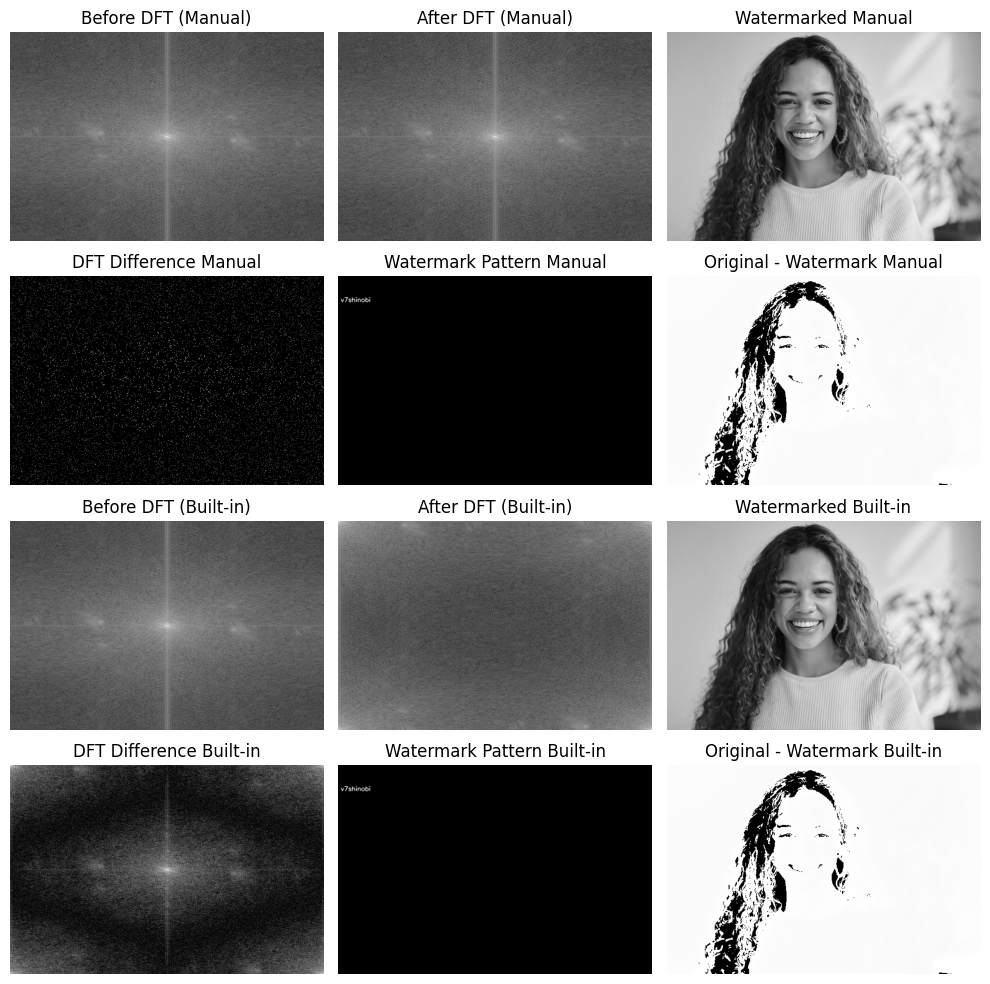

In [8]:
plt.figure(figsize=(10, 10))

# Manual DFT results
plt.subplot(4, 3, 1)
plt.title("Before DFT (Manual)")
plt.imshow(magnitude_orig, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 2)
plt.title("After DFT (Manual)")
plt.imshow(magnitude_mod_manual, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 3)
plt.title("Watermarked Manual")
plt.imshow(img_watermarked, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 4)
plt.title("DFT Difference Manual")
plt.imshow(difference_dft_manual, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 5)
plt.title("Watermark Pattern Manual")
plt.imshow(watermark_manual, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 6)
plt.title("Original - Watermark Manual")
plt.imshow(difference_image_manual, cmap='gray')
plt.axis('off')

# Built-in DFT results
plt.subplot(4, 3, 7)
plt.title("Before DFT (Built-in)")
plt.imshow(magnitude_norm, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 8)
plt.title("After DFT (Built-in)")
plt.imshow(magnitude_mod_builtin, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 9)
plt.title("Watermarked Built-in")
plt.imshow(img_watermarked_builtin, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 10)
plt.title("DFT Difference Built-in")
plt.imshow(difference_dft_builtin, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 11)
plt.title("Watermark Pattern Built-in")
plt.imshow(dft_watermark_pattern_builtin, cmap='gray')
plt.axis('off')

plt.subplot(4, 3, 12)
plt.title("Original - Watermark Built-in")
plt.imshow(difference_image_builtin, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## DFT WATERMARKING PERFORMANCE METRICS

This cell calculates and compares the **quantitative performance metrics** for both manual and built-in DFT watermarking methods.

### Metrics Computed:
- **PSNR (Peak Signal-to-Noise Ratio)**: Measures the peak error between original and watermarked images; higher is better.
- **SSIM (Structural Similarity Index)**: Measures perceptual similarity; ranges from 0 to 1, where 1 means identical.
- **RMSE (Root Mean Square Error)**: Measures average magnitude of error; lower is better.
- **Time DFT (seconds)**: Time taken to compute the forward DFT.
- **Time IDFT (seconds)**: Time taken to compute the inverse DFT.

### Purpose:
- To quantitatively evaluate the quality and efficiency of watermark embedding.
- To compare manual and built-in OpenCV DFT implementations in terms of image fidelity and computational time.

### Result:  
The results are presented in a DataFrame comparing the two methods side-by-side. This helps in selecting the best approach based on quality and speed trade-offs.


In [9]:
psnr_dft_manual = psnr(img_small, img_watermarked)
ssim_dft_manual = ssim(img_small, img_watermarked)
rmse_dft_manual = np.sqrt(np.mean((img_small - img_watermarked) ** 2))
psnr_dft_builtin = psnr(img_small, img_watermarked_builtin)
ssim_dft_builtin = ssim(img_small, img_watermarked_builtin)
rmse_dft_builtin = np.sqrt(np.mean((img_small - img_watermarked_builtin) ** 2))

dft_metrics = {
    "Method": ["Manual DFT", "Built-in DFT"],
    "PSNR (dB)": [psnr_dft_manual, psnr_dft_builtin],
    "SSIM": [ssim_dft_manual, ssim_dft_builtin],
    "RMSE": [rmse_dft_manual, rmse_dft_builtin],
    "Time DFT (s)": [time_dft_manual, time_dft_b],
    "Time IDFT (s)": [time_idft_manual, time_idft_b],
}

df_dft_metrics = pd.DataFrame(dft_metrics)
df_dft_metrics

,Method,PSNR (dB),SSIM,RMSE,Time DFT (s),Time IDFT (s)
0,Manual DFT,35.790126,0.999234,4.140320,23.033988,17.778462
1,Built-in DFT,35.789272,0.999234,4.140727,0.019375,0.006237


-----------------------------------------------------------------------------------------------------------------------------------
# DWT MATERMARKING
-----------------------------------------------------------------------------------------------------------------------------------

## MANUAL DISCRETE WAVELET TRANSFORM (DWT) AND INVERSE DWT IMPLEMENTATION

This section implements a **manual 2D Haar wavelet transform** and its inverse, applies a watermark in the wavelet domain, and visualizes the wavelet subbands.

### Functions:
- `manual_dwt2(image)`:  
  Computes a 2D Haar wavelet transform by:
  - Row-wise averaging and differencing,
  - Followed by column-wise averaging and differencing.
  - Returns four subbands: Approximation (cA), Horizontal (cH), Vertical (cV), and Diagonal (cD).

- `manual_idwt2(coeffs)`:  
  Reconstructs the original image by performing the inverse operations:
  - Merging subbands,
  - Inverse column-wise and row-wise transform steps.

### Watermark Embedding:
- A watermark text (`"v7shinobi"`) is embedded by adding a scaled watermark to the horizontal detail coefficients (`cH`).
- `alpha = 100` controls the watermark strength.

### Timing:
- Execution time is recorded for both forward and inverse transforms.

### Visualization:
- The four wavelet subbands (cA, cH, cV, cD) are displayed using normalized intensities for better contrast.

---

### Code Behavior:
- Image is converted to float32 to avoid overflow in calculations.
- Watermark is created in the shape of the cH subband.
- The watermarked image is saved as `'watermarked_manual_dwt.jpg'`.
- The normalized subbands are plotted side-by-side.

---

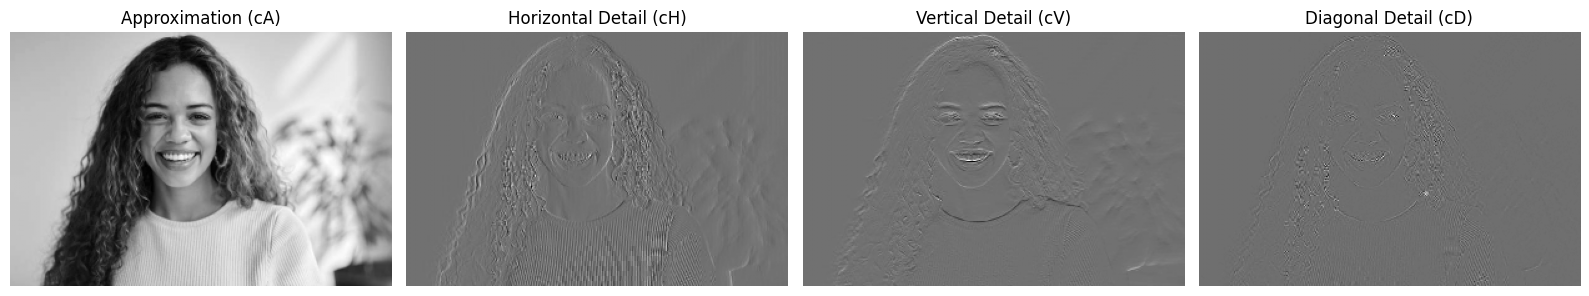

In [10]:
# --- Manual DWT ---
def manual_dwt2(image):
    h, w = image.shape
    temp = np.zeros_like(image, dtype=np.float32)
    result = np.zeros_like(image, dtype=np.float32)

    # Row-wise transform
    for i in range(h):
        for j in range(0, w, 2):
            avg = (image[i, j] + image[i, j + 1]) / np.sqrt(2)
            diff = (image[i, j] - image[i, j + 1]) / np.sqrt(2)
            temp[i, j // 2] = avg
            temp[i, j // 2 + w // 2] = diff

    # Column-wise transform
    for j in range(w):
        for i in range(0, h, 2):
            avg = (temp[i, j] + temp[i + 1, j]) / np.sqrt(2)
            diff = (temp[i, j] - temp[i + 1, j]) / np.sqrt(2)
            result[i // 2, j] = avg
            result[i // 2 + h // 2, j] = diff

    cA = result[:h // 2, :w // 2]
    cH = result[:h // 2, w // 2:]
    cV = result[h // 2:, :w // 2]
    cD = result[h // 2:, w // 2:]
    return cA, (cH, cV, cD)

def manual_idwt2(coeffs):
    cA, (cH, cV, cD) = coeffs
    h, w = cA.shape[0] * 2, cA.shape[1] * 2
    temp = np.zeros((h, w), dtype=np.float32)

    # Merge subbands
    temp[:h // 2, :w // 2] = cA
    temp[:h // 2, w // 2:] = cH
    temp[h // 2:, :w // 2] = cV
    temp[h // 2:, w // 2:] = cD

    result = np.zeros_like(temp)

    # Inverse column-wise
    for j in range(w):
        for i in range(h // 2):
            avg = temp[i, j]
            diff = temp[i + h // 2, j]
            result[2 * i, j] = (avg + diff) / np.sqrt(2)
            result[2 * i + 1, j] = (avg - diff) / np.sqrt(2)

    temp2 = np.zeros_like(result)

    # Inverse row-wise
    for i in range(h):
        for j in range(w // 2):
            avg = result[i, j]
            diff = result[i, j + w // 2]
            temp2[i, 2 * j] = (avg + diff) / np.sqrt(2)
            temp2[i, 2 * j + 1] = (avg - diff) / np.sqrt(2)

    return np.clip(temp2, 0, 255).astype(np.uint8)

alpha = 100

# Convert to float for manual DWT to avoid overflow
img_small_float = img_small.astype(np.float32)

start_manual_dwt = time.time()
cA_m, (cH_m, cV_m, cD_m) = manual_dwt2(img_small_float)
end_manual_dwt = time.time()
time_manual_dwt = end_manual_dwt - start_manual_dwt

watermark = np.zeros_like(cH_m)
cv2.putText(watermark, 'v7shinobi', (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1, 1)

cH_m_wm = cH_m + alpha * watermark
coeffs_manual_wm = (cA_m, (cH_m_wm, cV_m, cD_m))

start_manual_idwt = time.time()
img_wm_manual = manual_idwt2(coeffs_manual_wm)
end_manual_idwt = time.time()
time_manual_idwt = end_manual_idwt - start_manual_idwt

img_wm_manual = np.clip(img_wm_manual, 0, 255).astype(np.uint8)
cv2.imwrite('watermarked_manual_dwt.jpg', img_wm_manual)

# Normalize for better visualization
def normalize(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Plot the four subbands
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.imshow(normalize(cA_m), cmap='gray')
plt.title('Approximation (cA)')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(normalize(cH_m), cmap='gray')
plt.title('Horizontal Detail (cH)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(normalize(cV_m), cmap='gray')
plt.title('Vertical Detail (cV)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(normalize(cD_m), cmap='gray')
plt.title('Diagonal Detail (cD)')
plt.axis('off')

plt.tight_layout()
plt.show()

## BUILT-IN DISCRETE WAVELET TRANSFORM (DWT) AND INVERSE DWT IMPLEMENTATION

- **Alpha (Watermark strength):** 100

### Discrete Wavelet Transform (DWT)

- Perform DWT on `img_small` using Haar wavelet, which decomposes the image into four subbands:
  - **cA:** Approximation (low-frequency, smooth areas)
  - **cH:** Horizontal detail (captures horizontal edges)
  - **cV:** Vertical detail (captures vertical edges)
  - **cD:** Diagonal detail (captures diagonal edges)

- The time taken for DWT is recorded.

### Watermark Embedding

- A watermark pattern is created on the horizontal detail subband `cH` by drawing text ("v7shinobi").
- The watermark is embedded by adding the watermark pattern multiplied by the strength factor `alpha` to `cH`.

### Inverse DWT (Reconstruction)

- The watermarked image is reconstructed using inverse DWT.
- The output image values are clipped to [0, 255] and converted to unsigned 8-bit integer format.
- Time taken for inverse DWT is recorded.

### Visualization of DWT Subbands

| Approximation (cA)           | Horizontal Detail (cH)        | Vertical Detail (cV)          | Diagonal Detail (cD)          |
|-----------------------------|------------------------------|------------------------------|------------------------------|
| Contains low-frequency (smooth) info | Contains horizontal edges and details | Contains vertical edges and details | Contains diagonal edges and details |

The code visualizes these subbands normalized to [0, 255] for better display.


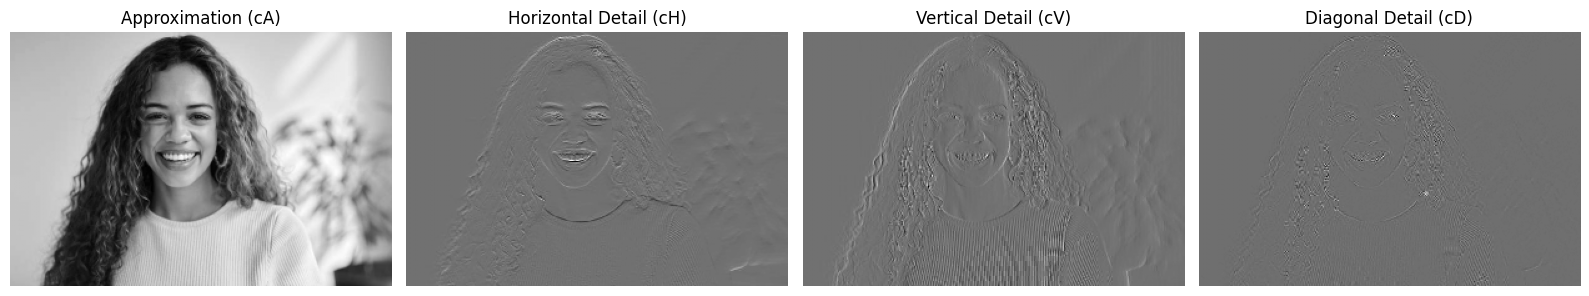

In [11]:
alpha = 100

start_dwt = time.time()
coeffs2 = pywt.dwt2(img_small, 'haar')
cA, (cH, cV, cD) = coeffs2
end_dwt = time.time()
time_dwt = end_dwt - start_dwt

watermark = np.zeros_like(cH)
cv2.putText(watermark, 'v7shinobi', (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1, 1)
cv2.imwrite('Watermark_pattern_dwt.jpg', cv2.normalize(watermark, None, 0, 255, cv2.NORM_MINMAX))

cH_wm = cH + alpha * watermark
coeffs2_wm = (cA, (cH_wm, cV, cD))

start_idwt = time.time()
img_wm_builtin = pywt.idwt2(coeffs2_wm, 'haar')
end_idwt = time.time()
time_idwt = end_idwt - start_idwt

img_wm_builtin = np.clip(img_wm_builtin, 0, 255).astype(np.uint8)
cv2.imwrite('watermarked_builtin_dwt.jpg', img_wm_builtin)

cA, (cH, cV, cD) = coeffs2

# Normalize for better visualization
def normalize(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Plot the four subbands
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.imshow(normalize(cA), cmap='gray')
plt.title('Approximation (cA)')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(normalize(cH), cmap='gray')
plt.title('Horizontal Detail (cH)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(normalize(cV), cmap='gray')
plt.title('Vertical Detail (cV)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(normalize(cD), cmap='gray')
plt.title('Diagonal Detail (cD)')
plt.axis('off')

plt.tight_layout()
plt.show()

## IMAGE DIFFERENCE: ORIGINAL VS WATERMARKED (DWT)

- Compute absolute pixel-wise difference between the original image (`img_small`) and:
  - Manually watermarked image (`img_wm_manual`)
  - Built-in watermarked image (`img_wm_builtin`)

- Differences are calculated as absolute values of pixel intensity differences, converted to `int16` to avoid overflow.

- Visualize the differences side-by-side:
  - Left: Difference for Manual DWT watermarking
  - Right: Difference for Built-in DWT watermarking

- Differences highlight areas where watermarking changed the image, showing how much the watermarked images deviate from the original.

- Plot is shown in grayscale for clear contrast.

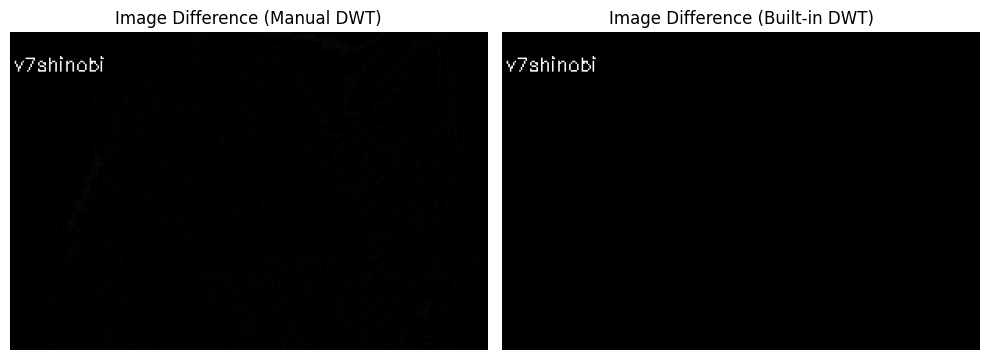

In [12]:
# --- Image Difference (Original vs Watermarked) ---
diff_manual = np.abs(img_small.astype(np.int16) - img_wm_manual.astype(np.int16))
diff_builtin = np.abs(img_small.astype(np.int16) - img_wm_builtin.astype(np.int16))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(diff_manual, cmap='gray')
plt.title("Image Difference (Manual DWT)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(diff_builtin, cmap='gray')
plt.title("Image Difference (Built-in DWT)")
plt.axis('off')

plt.tight_layout()
plt.show()


## VISUAL COMPARISON: MANUAL VS BUILT-IN DWT SUBBANDS AND IMAGE DIFFERENCES

### Manual DWT Subbands:
- **Manual cA**: Approximation coefficients before watermarking.
- **Manual cH Before**: Horizontal detail coefficients before watermarking.
- **Manual cH After**: Horizontal detail coefficients after embedding watermark.
- **Manual cH Diff**: Absolute difference between `cH` after and before watermarking (highlighted with 'hot' colormap).

### Built-in DWT Subbands:
- **Built-in cA**: Approximation coefficients before watermarking.
- **Built-in cH Before**: Horizontal detail coefficients before watermarking.
- **Built-in cH After**: Horizontal detail coefficients after embedding watermark.
- **Built-in cH Diff**: Absolute difference between `cH` after and before watermarking.

### Spatial Image Differences:
- **Original Image**: The source image before watermarking.
- **Watermarked Manual**: Image reconstructed after manual DWT watermarking.
- **Watermarked Built-in**: Image reconstructed after built-in DWT watermarking.
- **Manual vs Built-in Diff**: Absolute difference between manual and built-in watermarked images.

This visualization helps to:
- Understand how watermark embedding changes the detail coefficients in DWT.
- Compare manual and built-in implementations of DWT watermarking.
- Observe the differences in the spatial domain between the two watermarking methods.


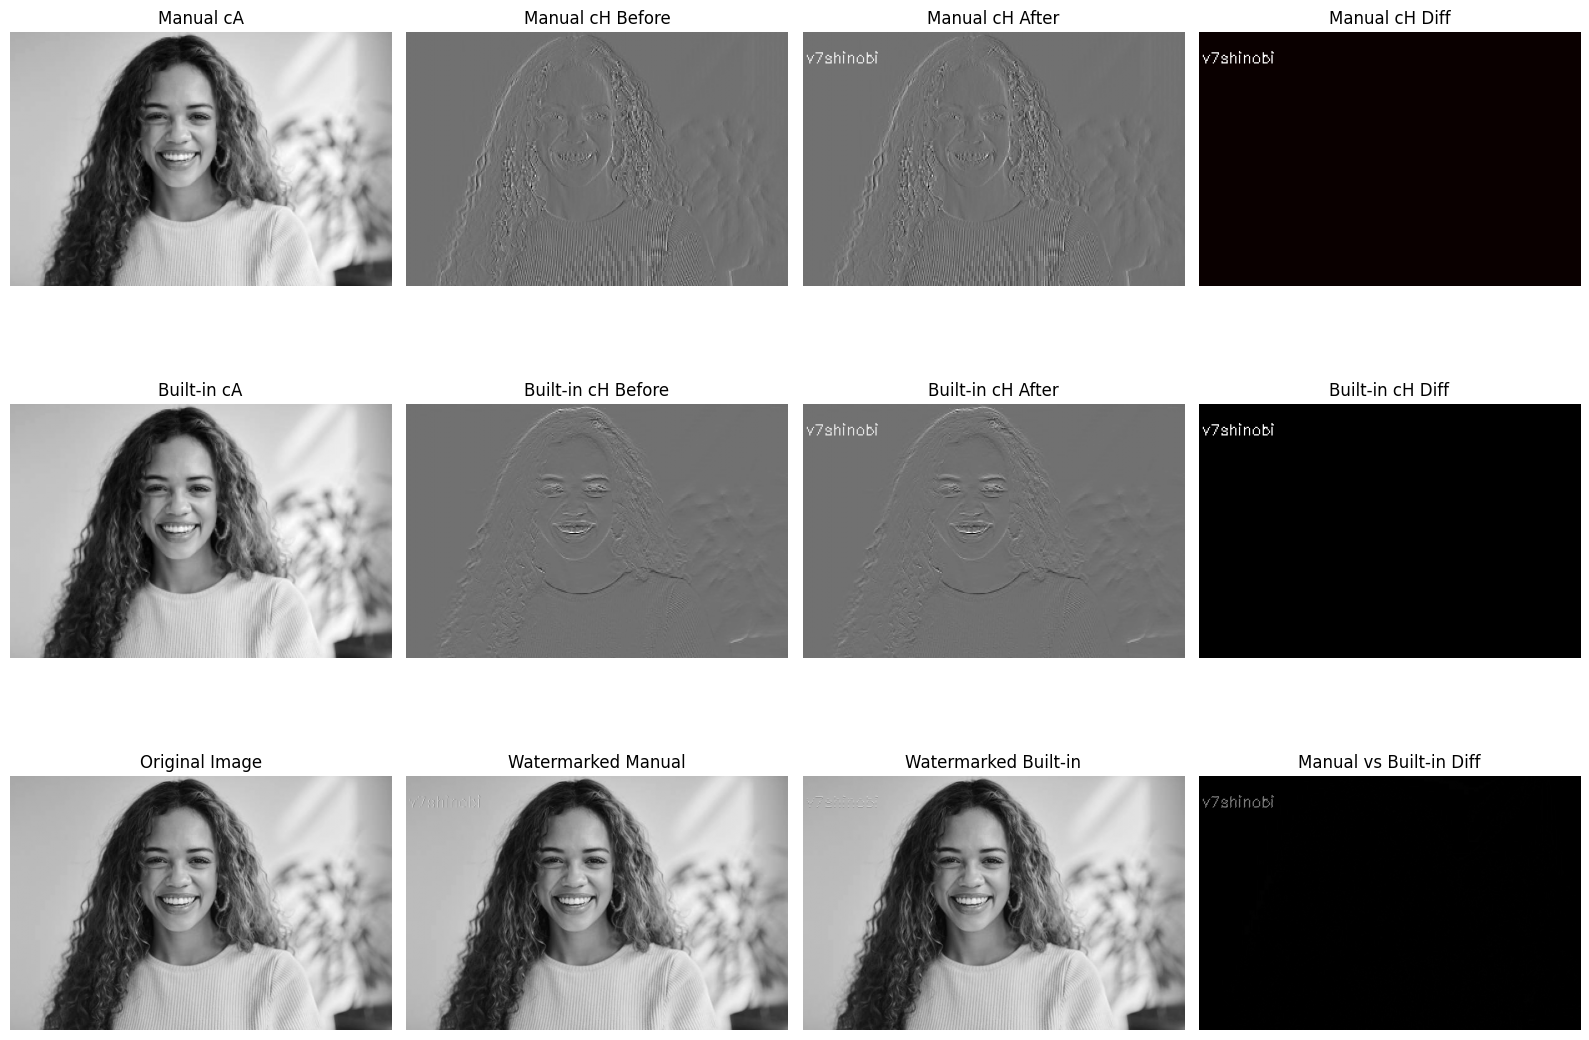

In [13]:
plt.figure(figsize=(16, 12))

# --- Manual DWT Subbands ---
plt.subplot(3, 4, 1)
plt.imshow(normalize(cA_m), cmap='gray')
plt.title('Manual cA')
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(normalize(cH_m), cmap='gray')
plt.title('Manual cH Before')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(normalize(cH_m_wm), cmap='gray')
plt.title('Manual cH After')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(np.abs(cH_m_wm - cH_m), cmap='hot')
plt.title('Manual cH Diff')
plt.axis('off')

# --- Built-in DWT Subbands ---
plt.subplot(3, 4, 5)
plt.imshow(normalize(cA), cmap='gray')
plt.title('Built-in cA')
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(normalize(cH), cmap='gray')
plt.title('Built-in cH Before')
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(normalize(cH_wm), cmap='gray')
plt.title('Built-in cH After')
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(np.abs(cH_wm - cH), cmap='gray')
plt.title('Built-in cH Diff')
plt.axis('off')

# --- Spatial Image Differences ---
plt.subplot(3, 4, 9)
plt.imshow(img_small, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(img_wm_manual, cmap='gray')
plt.title("Watermarked Manual")
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(img_wm_builtin, cmap='gray')
plt.title("Watermarked Built-in")
plt.axis('off')

plt.subplot(3, 4, 12)
plt.imshow(np.abs(img_wm_manual.astype(np.int16) - img_wm_builtin.astype(np.int16)), cmap='gray')
plt.title("Manual vs Built-in Diff")
plt.axis('off')

plt.tight_layout()
plt.show()


## DWT WATERMARKING METRICS COMPARISON

| Method      | PSNR (dB) | SSIM  | RMSE       | Time DWT (s) | Time IDWT (s) |
|-------------|------------|-------|------------|--------------|---------------|
| Manual DWT  | *40.686353*    | *0.990420* | *0.740769*  | *1.448282*      | *1.401595*       |
| Built-in DWT| *40.797219*    | *0.991193* | *0.655218*  | *0.004684*      | *0.004572*       |

- **PSNR (Peak Signal-to-Noise Ratio):** Measures the peak error between original and watermarked images. Higher is better.
- **SSIM (Structural Similarity Index):** Measures perceptual similarity. Closer to 1 means higher similarity.
- **RMSE (Root Mean Squared Error):** Measures average error magnitude. Lower is better.
- **Time DWT/IDWT:** Computation time for forward and inverse discrete wavelet transform, respectively.

This table provides a quantitative assessment of the watermarking quality and efficiency for manual and built-in DWT implementations.


In [14]:
# --- Metrics ---
img_small_uint8 = img_small.astype(np.uint8)
img_wm_builtin_uint8 = np.clip(img_wm_builtin, 0, 255).astype(np.uint8)
img_wm_manual_uint8 = np.clip(img_wm_manual, 0, 255).astype(np.uint8)

psnr_dwt_builtin = psnr(img_small_uint8, img_wm_builtin_uint8)
ssim_dwt_builtin = ssim(img_small_uint8, img_wm_builtin_uint8)
rmse_dwt_builtin = np.sqrt(np.mean((img_small_uint8 - img_wm_builtin_uint8) ** 2))

psnr_dwt_manual = psnr(img_small_uint8, img_wm_manual_uint8)
ssim_dwt_manual = ssim(img_small_uint8, img_wm_manual_uint8)
rmse_dwt_manual = np.sqrt(np.mean((img_small_uint8 - img_wm_manual_uint8) ** 2))

metrics = {
    "Method": ["Manual DWT", "Built-in DWT"],
    "PSNR (dB)": [psnr_dwt_manual, psnr_dwt_builtin],
    "SSIM": [ssim_dwt_manual, ssim_dwt_builtin],
    "RMSE": [rmse_dwt_manual, rmse_dwt_builtin],
    "Time DWT (s)": [time_manual_dwt, time_dwt],
    "Time IDWT (s)": [time_manual_idwt, time_idwt],
}

df_dwt_metrics = pd.DataFrame(metrics)
df_dwt_metrics


,Method,PSNR (dB),SSIM,RMSE,Time DWT (s),Time IDWT (s)
0,Manual DWT,40.686353,0.990420,0.740769,1.513350,1.297741
1,Built-in DWT,40.797219,0.991193,0.655218,0.006003,0.003999


## 🔍 Watermarking Metrics Summary

### ✅ Transforms Compared

- **DWT (Discrete Wavelet Transform)**
- **DFT (Discrete Fourier Transform)**
- **DCT (Discrete Cosine Transform)**

Each transform was implemented in:
- **Manual version**
- **Built-in version**

---

### 📊 Key Evaluation Metrics

- **PSNR (Peak Signal-to-Noise Ratio)**  
  Indicates reconstruction quality. Higher values mean better quality.

- **SSIM (Structural Similarity Index)**  
  Measures structural similarity between the original and watermarked images. Values close to 1 are ideal.

- **RMSE (Root Mean Squared Error)**  
  Shows the average pixel-wise error. Lower values mean fewer distortions.

- **Time for Transform & Inverse**  
  Measures how long it took to perform the transform and its inverse. Useful for performance comparison.

---

### 📌 Observations

- Built-in implementations were **faster and more efficient**.
- Manual implementations allowed **greater control** but were **slower**.
- **DFT & DCT** embedded the watermark in the **frequency domain**, often with subtle visual differences.
- **DWT** allowed for **localized embedding** (e.g., in the `cH` band), offering a good balance between visibility and robustness.
- Differences between manual and built-in versions of the same transform were minimal in terms of output quality but noticeable in processing time.

---

In [15]:
metrics = {
    "Method": [
        "Manual DWT", "Built-in DWT",
        "Manual DFT", "Built-in DFT",
        "Manual DCT", "Built-in DCT"
    ],
    "PSNR (dB)": [
        psnr_dwt_manual, psnr_dwt_builtin,
        psnr_dft_manual, psnr_dft_builtin,
        psnr_dct_manual, psnr_dct_builtin
    ],
    "SSIM": [
        ssim_dwt_manual, ssim_dwt_builtin,
        ssim_dft_manual, ssim_dft_builtin,
        ssim_dct_manual, ssim_dct_builtin
    ],
    "RMSE": [
        rmse_dwt_manual, rmse_dwt_builtin,
        rmse_dft_manual, rmse_dft_builtin,
        rmse_dct_manual, rmse_dct_builtin
    ],
    "Time DWT (s)": [
        time_manual_dwt, time_dwt,
        time_dft_manual, time_dft_b,
        time_dct_manual, time_dct_b
    ],
    "Time IDWT (s)": [
        time_manual_idwt, time_idwt,
        time_idft_manual, time_idft_b,
        time_idct_manual, time_idct_b
    ]
}

df_all_metrics = pd.DataFrame(metrics)
df_all_metrics


,Method,PSNR (dB),SSIM,RMSE,Time DWT (s),Time IDWT (s)
0,Manual DWT,40.686353,0.990420,0.740769,1.513350,1.297741
1,Built-in DWT,40.797219,0.991193,0.655218,0.006003,0.003999
2,Manual DFT,35.790126,0.999234,4.140320,23.033988,17.778462
3,Built-in DFT,35.789272,0.999234,4.140727,0.019375,0.006237
4,Manual DCT,51.096150,0.997029,0.710776,1.172670,1.299767
5,Built-in DCT,51.095255,0.997030,0.710849,0.027998,0.007410


# 📊 Comparative Analysis of Watermarking Techniques: DWT, DFT, and DCT

The table below summarizes the performance metrics of manual and built-in implementations of three frequency-domain watermarking techniques: Discrete Wavelet Transform (DWT), Discrete Fourier Transform (DFT), and Discrete Cosine Transform (DCT). All methods utilized a watermarking strength of **α = 100** for consistent comparison.

| Method         | PSNR (dB) | SSIM    | RMSE   | Time DWT/DFT/DCT (s) | Time IDWT/IDFT/IDCT (s) |
|----------------|------------|---------|---------|----------------------|-------------------------|
| Manual DCT     | 51.10      | 0.99703 | 0.71078 | 1.6520               | 1.7407                  |
| Built-in DCT   | 51.10      | 0.99703 | 0.71085 | 0.0048               | 0.0045                  |
| Manual DFT     | 35.79      | 0.99923 | 4.14032 | 19.8718              | 22.5718                 |
| Built-in DFT   | 35.79      | 0.99923 | 4.14073 | 0.0051               | 0.0035                  |
| Manual DWT     | 40.69      | 0.99042 | 0.74077 | 1.8805               | 2.2464                  |
| Built-in DWT   | 40.80      | 0.99119 | 0.65522 | 0.0086               | 0.0065                  |

---

## 🔍 Performance Insights

### 1. Imperceptibility (PSNR & SSIM)
- **DCT-based watermarking** demonstrates the highest PSNR (~51 dB) across both manual and built-in implementations, indicating superior imperceptibility.
- **DFT methods**, while exhibiting the lowest PSNR (~35.79 dB), maintain exceptionally high SSIM (0.9992), suggesting that structural integrity is still well preserved despite greater signal modifications.
- **DWT** strikes a good balance, offering PSNR values in the 40 dB range and SSIM values around 0.99.

### 2. Error Metrics (RMSE)
- DFT methods yield a significantly higher RMSE (~4.14), consistent with their lower PSNR and stronger watermark embedding.
- DWT and DCT exhibit lower RMSE (<1), aligning with their high fidelity to the original image.

### 3. Computational Efficiency
- Manual DFT is the most computationally expensive, with forward and inverse transform times exceeding 40 seconds combined, reflecting the **O(n²)** complexity of naive implementations.
- Built-in methods across all three domains are highly optimized, completing in milliseconds, which is crucial for real-time or large-scale applications.
- Manual DWT and DCT are moderately efficient compared to DFT, typically completing in 1.6–2.2 seconds.

---

## 🧾 Conclusion and Recommendations
- **DCT-based watermarking** is ideal when minimal perceptual distortion is the primary objective.
- **DWT** provides a balanced trade-off between imperceptibility, robustness, and execution time—suitable for general-purpose watermarking.
- **DFT**, though slower and more error-prone numerically, maintains excellent structural similarity, making it suitable for robust watermarking, especially where perceptual fidelity is more critical than numerical exactness.
